# Introduction to Astrometry Notebook

We're going to take sources from an HSC observation and match them to Gaia, look at the separations, then fit the wcs and look at  focal plane distortions, finally we'll look at the effect of proper motions, then apply proper motions and parallax and redo the fit. 

If that is too fast, also fit the source positions.
Potential extras: do a better fit using error of measurements, try to find bug in astropy proper motion.

#### First, load some helpful packages:

In [1]:
# Start by loading some helpful packages:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.wcs
import astropy.units as u
from astropy.io import fits
from astropy import wcs
import pandas as pd
from glob import glob
import re

Normally, I wouldn't recommend suppressing warning messages, but in this case astropy will complain a lot about the input files, so it's helpful here:

In [3]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

## Part 1: Fitting a WCS

#### 1. Matching sources to a reference catalog

We start by loading the sample data sets. In the "astrometry_data" subdirectory, there are files containing the sources measured in one HSC exposure. There is one file for each detector. These source catalogs only contain isolated stars that are appropriate for fitting the astrometric solution (i.e., there are no galaxies or stars that are close to galaxies). There is also one file with a subset of the Gaia catalog overlapping the footprint of the HSC exposure.

First, load the Gaia catalog:
(In this Gaia catalog, missing entries are denoted by NaNs, so you probably want to filter these out.)

In [89]:
gaia_cat = pd.read_parquet('astrometry_data/gaia_refCat.parquet')
good_ids = np.isfinite(gaia_cat['coord_ra'])
print(len(gaia_cat))
gaia_cat = gaia_cat[good_ids]
gaia_cat
gaia_skyCoord = SkyCoord(gaia_cat.coord_ra, gaia_cat.coord_dec,
                         frame="icrs", unit="rad") # complete

13005


The files "astrometry_data/1180_\<detector\>.fits" contain the sources from each detector for visit 1180. The fits files have a best guess for the WCS in the primary HDU and the table of sources in the second HDU.

Let's start by just looking at one source catalog:

In [199]:
sources    = fits.open('astrometry_data/1180_42.fits')
source_wcs = sources[0]
source_cat = sources[1] # complete

# You can check the column names of the data:
Nobjects = np.array(source_cat.data).shape[0]
pixel_x = source_cat.data['x']
pixel_y = source_cat.data['y']

pixel_xy = []
for x,y in zip(source_cat.data['x'], source_cat.data['y']):
    pixel_xy.append((x,y))

    

Now convert the source catalog pixel values to RA and Dec using the WCS in the header

In [200]:
detector_wcs = wcs.WCS(header=source_wcs.header) # complete

# Hint: wcs has a pixel_to_world method that is helpful here
source_skyCoords = detector_wcs.pixel_to_world(pixel_x, pixel_y) # complete 

Make a plot showing the RA and Dec positions of the two catalogs to make sure we are starting with something sensible. For example, first make sure that the RA and Dec values of the two catalogs overlap, which they should. (Mixing up degrees and radians happens all the time!) Does it look like there are any likely matches between the catalogs? I recommend using different markers for each catalog in your scatter plot.

(2.0842375457739024, 2.1768979955136154)

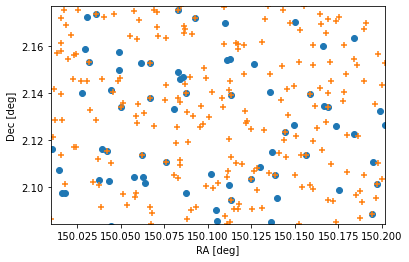

In [236]:
# Complete
plt.scatter(gaia_skyCoord.ra, gaia_skyCoord.dec)
plt.scatter(source_skyCoords.ra, source_skyCoords.dec, marker='+')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.xlim(min(source_skyCoords.ra.value), max(source_skyCoords.ra.value))
plt.ylim(min(source_skyCoords.dec.value), max(source_skyCoords.dec.value))

Given the initial estimate of RA and Dec, match the Gaia catalog sources to the new source catalog:

In [216]:
# Complete: 
# (Hint: astropy SkyCoord has a "match_to_catalog_sky" function that works well for this.)
idx_in_base_catalog, sep2d, _ = source_skyCoords.match_to_catalog_sky(gaia_skyCoord)
sep2d = sep2d.arcsecond

Not every source in the catalog will have a match in the Gaia catalog. Make a histogram of the match separations and choose a sensible limit for the distance between matches.

Text(0, 0.5, 'Counts')

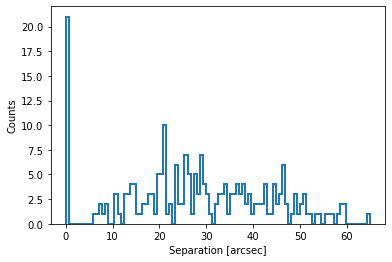

In [222]:
# Complete
plt.hist(sep2d, bins=100, histtype='step', lw=2)
plt.xlabel('Separation [arcsec]')
plt.ylabel('Counts')

Make a histogram of just the good matches to see what the separations look like.

Text(0, 0.5, 'Counts')

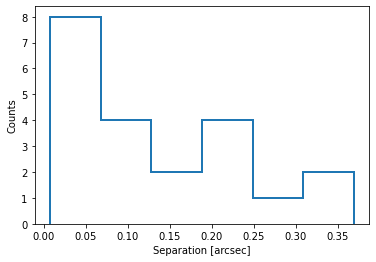

In [224]:
# Complete
good_match = sep2d < 5
plt.hist(sep2d[good_match], bins='auto', histtype='step', lw=2)
plt.xlabel('Separation [arcsec]')
plt.ylabel('Counts')

You may also want to remove any sources that have ambiguous pairings (within the limit you selected above) -- i.e. one gaia star matches multiple science sources or vice-versa

In [227]:
idx_in_base_good = idx_in_base_catalog[good_match]
sep2d_good       = sep2d[good_match]
print('removed %i sources' % (len(idx_in_base_catalog)-len(idx_in_base_good)))
print('left with %i sources' % len(idx_in_base_good))

removed 195 sources
left with 21 sources


In [230]:
# come back to this!
import collections
repeated_gaia_sources = [item for item, count in collections.Counter(idx_in_base_good).items() if count > 1]

#### 2. Fitting a WCS

Now that we have found the stars that are in both our science image and our reference catalog, let's try to fit an improved WCS.

To do a simple version of this, use `astropy.wcs.utils.fit_wcs_from_points` to fit a WCS function. Use the optional argument `sip_degree` to choose what order of polynomial to use for the function. (Choosing zero should give something pretty close to the WCS we got from the fits file header.) The pixel values should come from our source catalog, and the sky coordinates should come from the Gaia catalog.

In [210]:
# for coord in pixel_xy:
new_wcs = astropy.wcs.utils.fit_wcs_from_points((pixel_x, pixel_y),
                                                gaia_skyCoord,
                                                sip_degree=1)

ValueError: operands could not be broadcast together with shapes (10278,) (216,) 

Now calculate the RA and Dec for the pixel coordinages in the input image and see if the separations between the science image and Gaia have improved.

In [ ]:
new_radec = # complete

#### 3. Fit the WCS over the whole focal plane and look for camera-level effects

We are going to put the above steps together in a loop over all the detectors to get an improved WCS for each detector. 

In [ ]:
source_files = glob('astrometry_data/1180_*.fits')
get_detector = re.compile(r'astrometry_data/1180_(\d+?).fits')
orig_wcs_dict = {}
new_wcs_dict = {}
for source_file in source_files:
    sources = # complete
    
    s = get_detector.search(source_file)
    detector = int(s.group(1))

    orig_wcs_dict[detector] = # complete

    source_cat = # complete

    source_coords = # complete

    # Choose good matches as above...

    new_wcs = # complete
    new_wcs_dict[detector] = new_wcs


Plot the difference in RA and Dec vs the simple wcs position, then look at this difference over the focal plane. Are there coherent distortions between detectors?

To do this, I recommend making a grid in x and y pixel values and calculating what RA and Dec those map to using the original and new WCSs for each detector. 

In [ ]:
x_range = np.arange(0, 2048, 100)
y_range = np.arange(0, 4096, 100)

# complete

#### 4. How good is the model?

Use the pixel scale matrix (the CD matrix) to approximate the WCS Jacobian and propagate the x and y errors to RA and Dec. You can use this equation for the error propagation:

$$ \mathbf{C}_{RA, Dec} = \mathbf{J} \mathbf{C}_{x, y} \mathbf{J}^T
$$

where $\mathbf{C}_{x, y}$ is the x,y covariance matrix, \mathbf{C}_{RA, Dec} is the covariance in RA and Dec, and \mathbf{J} is the Jacobian of the WCS transformation.


In [ ]:
print(new_wcs.pixel_scale_matrix)

Using this covariance, calculated the chi-squared of the model for the WCS that we have calculated.